In [1]:
# import required libraries 
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn
import keras

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

from numpy import array

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import gc

from scipy import stats

import warnings
import logictensornetworks as ltn
import re
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
warnings.filterwarnings("ignore")

get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mae']), 
           label='Train')
    plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val')
    plt.legend()
    plt.ylim([0,max(history.history['val_mae'])])

def plot_prediction(test_labels, test_predictions):
    plt.figure()
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [1000$]')
    plt.ylabel('Predictions [1000$]')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])

    plt.figure()
    error = test_predictions - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error [1000$]")
    _ = plt.ylabel("Count")

# Data pre-processing

In [3]:
df1 = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/CICIDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", skipinitialspace = True)
df2 = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/CICIDS2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", skipinitialspace = True)

#df1 - dataset cu conexiuni DDoS si Benign
#df2 - dataset cu conexiuni PortScan si Benign

dataset = pd.concat([df1,df2]).drop_duplicates(keep=False)
dataset.reset_index(drop=True, inplace = True)

In [4]:
col_names = [col.replace(' ', '') for col in dataset.columns]
dataset.columns = col_names
dataset.head()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
label_names = dataset['Label'].unique()

label_names = [re.sub("[^a-zA-Z ]+", "", l) for l in label_names]
label_names = [re.sub("[\s\s]", '_', l) for l in label_names]
label_names = [lab.replace("__", "_") for lab in label_names]

label_names, len(label_names)

(['BENIGN', 'DDoS', 'PortScan'], 3)

In [6]:
labels = dataset['Label'].unique()

for i in range(0,len(label_names)):
    dataset['Label'] = dataset['Label'].replace({labels[i] : label_names[i]})
    
dataset['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan'], dtype=object)

In [7]:
dataset.dropna(inplace=True)

In [8]:
labl = dataset[['Label']]
dataset = dataset.loc[:, dataset.columns != 'Label'].astype('float64')

In [9]:
dataset = dataset.replace([np.inf, -np.inf], np.nan)

In [10]:
dataset = dataset.merge(labl, how='outer', left_index=True, right_index=True)

In [11]:
dataset.dropna(inplace=True)

In [12]:
dataset.Label.value_counts()

BENIGN      212718
DDoS        128005
PortScan     57305
Name: Label, dtype: int64

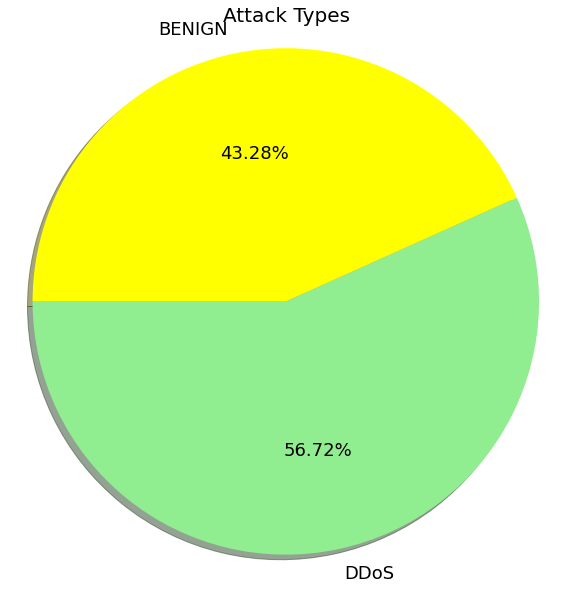

In [13]:

import matplotlib.pyplot as plt

labels= ['DDoS', 'BENIGN', 'PortScan']

colors=['lightgreen', 'yellow', 'green']

x= [212718, 128005, 57305]
explode = [0, 0, 0]
fig, ax = plt.subplots()
ax.pie(x, labels = labels,
          textprops={'fontsize': 18},
          colors = colors,
          autopct='%.2f%%',
          explode = explode,
          shadow = True,
          startangle = 180)
fig = plt.gcf()
fig.set_size_inches(10,10) # or (4,4) or (5,5) or whatever
plt.title('Attack Types', fontsize = 20)
#plt.savefig('Pie_chart_multi.png')
plt.axis('equal')


plt.show()

In [14]:
features = dataset.loc[:, dataset.columns != 'Label'].astype('float64')

In [15]:
labels=pd.DataFrame()
labels["Label"] = dataset['Label']
features = dataset.loc[:, dataset.columns != 'Label'].astype('float64')

In [16]:
scaler = RobustScaler()
scaler.fit(features)

features = scaler.transform(features)

### DDoS -> 0
### BENIGN -> 1

In [17]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

LE.fit(labels["Label"])
labels["Label"] = LE.transform(labels["Label"])

In [18]:
labels.value_counts()

Label
0        212718
1        128005
2         57305
dtype: int64

### Split data 80% training, 20% testing

In [19]:
label_label = labels["Label"]

features_train, features_test, labels_train, labels_test = train_test_split(features, label_label, test_size=.2)

features_train.shape, features_test.shape, labels_train.shape, labels_test.shape

((318422, 78), (79606, 78), (318422,), (79606,))

### 2D input -> 3D input

In [20]:
sample_size = features_train.shape[0] # number of samples in train set
time_steps  = features_train.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

features_train_reshaped = features_train.reshape(sample_size,time_steps,input_dimension)
features_test_reshaped = features_test.reshape(features_test.shape[0],features_test.shape[1],1)


### Create batches of tensors from input data

In [21]:
batch_size = 5096
ds_train = tf.data.Dataset.from_tensor_slices((features_train_reshaped,labels_train)).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((features_test_reshaped,labels_test)).batch(batch_size)

Metal device set to: Apple M1


2022-07-24 18:31:16.425294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-24 18:31:16.425411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
def build_conv1D_model():

    n_timesteps = features_train_reshaped.shape[1] 
    n_features  = features_train_reshaped.shape[2]  
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=128, kernel_size=14, activation='elu', name="Conv1D_1"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='elu', name="Conv1D_2"))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='elu', name="Conv1D_3"))
  
    model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='elu', name="Conv1D_4"))
  
    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(keras.layers.Flatten())
    #model.add(keras.layers.Dense(2, activation='elu', name="Dense_1"))
    #model.add(keras.layers.Dense(1, activation = 'sigmoid', name="Dense_2"))

#     model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
    return model


logits_model = build_conv1D_model()
p = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model,single_label=True))

In [23]:
print(logits_model.summary())

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 65, 128)           1920      
                                                                 
 dropout (Dropout)           (None, 65, 128)           0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 59, 64)            57408     
                                                                 
 Conv1D_3 (Conv1D)           (None, 57, 32)            6176      
                                                                 
 Conv1D_4 (Conv1D)           (None, 56, 16)            1040      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 28, 16)           0         
                                                                 
 flatten (Flatten)           (None, 448)              

In [24]:
class_A = ltn.Constant(0, trainable=False)
class_B = ltn.Constant(1, trainable=False)
class_C = ltn.Constant(2, trainable=False)

### Connectors and quantifier

In [25]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")

### Axioms - Knowledge Base


In [26]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))
# valoarea lui p schimba mult rezultatele, este explicata mai bine in articolul nostru de pe overleaf
# cu o valoare mai mica sunt si rezultate mai slabe in acest caz unde sunt doar doua clase

@tf.function
def axioms(features, labels, training=False):
    x_A = ltn.Variable("x_A",features[labels==0])
    x_B = ltn.Variable("x_B",features[labels==1])
    x_C = ltn.Variable("x_C",features[labels==2])
    axioms = [
        Forall(x_A,p([x_A,class_A],training=training)),
        Forall(x_B,p([x_B,class_B],training=training)),
        Forall(x_C,p([x_C,class_C],training=training)),
        # lipsesc constrangerile, fiind un numar mic de clase
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

In [27]:
# este necesara initializarea aceasta inainte de antrenare
for features, labels in ds_test:
    print("Initial sat level %.5f"%axioms(features,labels))
    break

2022-07-24 18:31:17.655474: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-24 18:31:17.656279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Initial sat level 0.00161


In [28]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb'),
    'train_accuracy': tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")
}

In [29]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) - rezultate similare
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def train_step(features, labels):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(features, labels, training=True)
        loss = 1.-sat
    gradients = tape.gradient(loss, p.trainable_variables)
    optimizer.apply_gradients(zip(gradients, p.trainable_variables))
    sat = axioms(features, labels) # compute sat without dropout
    metrics_dict['train_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['train_accuracy'](tf.one_hot(labels,3),predictions)
    
@tf.function
def test_step(features, labels):
    # sat
    sat = axioms(features, labels)
    metrics_dict['test_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['test_accuracy'](tf.one_hot(labels,3),predictions)

In [30]:
from collections import defaultdict

def train(
        epochs,
        metrics_dict, 
        ds_train, 
        ds_test, 
        train_step, 
        test_step,
        track_metrics=1,
        csv_path=None,
        scheduled_parameters=defaultdict(lambda : {})
    ):
    """
    Args:
        epochs: int, number of training epochs.
        metrics_dict: dict, {"metrics_label": tf.keras.metrics instance}.
        ds_train: iterable dataset, e.g. using tf.data.Dataset.
        ds_test: iterable dataset, e.g. using tf.data.Dataset.
        train_step: callable function. the arguments passed to the function
            are the itered elements of ds_train.
        test_step: callable function. the arguments passed to the function
            are the itered elements of ds_test.
        csv_path: (optional) path to create a csv file, to save the metrics.
        scheduled_parameters: (optional) a dictionary that returns kwargs for
            the train_step and test_step functions, for each epoch.
            Call using scheduled_parameters[epoch].
    """
    template = "Epoch {}"
    for metrics_label in metrics_dict.keys():
        template += ", %s: {:.4f}" % metrics_label
    if csv_path is not None:
        csv_file = open(csv_path,"w+")
        headers = ",".join(["Epoch"]+list(metrics_dict.keys()))
        csv_template = ",".join(["{}" for _ in range(len(metrics_dict)+1)])
        csv_file.write(headers+"\n")
    
    for epoch in range(epochs):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train:
            train_step(*batch_elements,**scheduled_parameters[epoch])
        for batch_elements in ds_test:
            test_step(*batch_elements,**scheduled_parameters[epoch])

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        if epoch%track_metrics == 0:
            print(template.format(epoch,*metrics_results))
        if csv_path is not None:
            csv_file.write(csv_template.format(epoch,*metrics_results)+"\n")
            csv_file.flush()
    if csv_path is not None:
        csv_file.close()

In [31]:
EPOCHS = 50

train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="results_copie.csv",
    track_metrics=1
)

2022-07-24 18:31:19.200986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-24 18:33:00.167332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-24 18:33:01.742775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-24 18:33:11.074369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 0, train_sat_kb: 0.1990, test_sat_kb: 0.2761, train_accuracy: 0.2282, test_accuracy: 0.2861
Epoch 1, train_sat_kb: 0.3168, test_sat_kb: 0.3836, train_accuracy: 0.3758, test_accuracy: 0.5190
Epoch 2, train_sat_kb: 0.3935, test_sat_kb: 0.4005, train_accuracy: 0.5393, test_accuracy: 0.5520
Epoch 3, train_sat_kb: 0.4113, test_sat_kb: 0.4216, train_accuracy: 0.5697, test_accuracy: 0.5823
Epoch 4, train_sat_kb: 0.4962, test_sat_kb: 0.5791, train_accuracy: 0.6556, test_accuracy: 0.7324
Epoch 5, train_sat_kb: 0.6054, test_sat_kb: 0.6082, train_accuracy: 0.7553, test_accuracy: 0.7580
Epoch 6, train_sat_kb: 0.7140, test_sat_kb: 0.7673, train_accuracy: 0.8655, test_accuracy: 0.9186
Epoch 7, train_sat_kb: 0.8052, test_sat_kb: 0.8155, train_accuracy: 0.9422, test_accuracy: 0.9500
Epoch 8, train_sat_kb: 0.8269, test_sat_kb: 0.8269, train_accuracy: 0.9554, test_accuracy: 0.9558
Epoch 9, train_sat_kb: 0.8258, test_sat_kb: 0.8433, train_accuracy: 0.9542, test_accuracy: 0.9638
Epoch 10, train_sat_